In [1]:
import ROOT
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

sys.path.append("../python/")
sys.path.append("/eos/home-y/yabulait/wjets/time-odd-asymmetry")
from context import (Luminosity_fb, Luminosity_pb, grid_date, leptons,mc_processes, samples)
import json
from wjetsAsymmetryFrame import *

#set Multi-thread enabled.
ROOT.ROOT.EnableImplicitMT(32)

Welcome to JupyROOT 6.20/02


In [2]:

def get_asymetry_hist(func):
    def wrapper(*args, **kwargs):
        rdf_data, dsid = func(*args, **kwargs)
        if mc_process is "wjets": rdf_data = rdf_data.Filter('abs(mcEventWeight)<100')
        b_veto = rdf_data.Filter("(nbjet<1)&&mT>50&&qT>30") # hope this will getrid of ttbar
        df_positive_deta_lj = b_veto.Filter("deta_lj >1.0")
        df_positive_Xprep06 = b_veto.Filter("Xprep > 0.6")
        df_negetive_Xprep06 = b_veto.Filter("Xprep < -0.6")
        hist, h_deta_p, h_deta_n = None, None, None
        if dsid == "410470":
            hist = df_positive_deta_lj.Histo1D(("Xprep","Xprep",100,-3.5,3.5), "Xprep")
            h_deta_p = df_positive_Xprep06.Histo1D(("hEtaPlus","hEtaPlus",16,-4,4), "deta_lj")
            h_deta_n = df_negetive_Xprep06.Histo1D(("hEtaMinus","hEtaMinus",16,-4,4), "deta_lj")
        else:
            hist = df_positive_deta_lj.Histo1D(("Xprep","Xprep",100,-3.5,3.5), "Xprep","mcEventWeight")
            h_deta_p = df_positive_Xprep06.Histo1D(("hEtaPlus","hEtaPlus",16,-4,4), "deta_lj","mcEventWeight")
            h_deta_n = df_negetive_Xprep06.Histo1D(("hEtaMinus","hEtaMinus",16,-4,4), "deta_lj","mcEventWeight")
        return dsid, hist, h_deta_p, h_deta_n
    return wrapper

@get_asymetry_hist
def get_rdf(file,branches=np.array(["mcEventWeight", "deta_lj", "Xprep","nbjet", "mT", "qT"])):
    wjets = wjetsAsymmetryFrame()
    df_preSelected = wjets.load_raw_data(files=[file], branches=branches)
    dsid = file.split('/')[-1]
    dsid = dsid.split('.')[0]
    return  df_preSelected, dsid

event_weights = None
with open("../data/{}/sample_weights.txt".format(grid_date),"r") as f:
    event_weights= json.load( f)

def calculate_asymmetry(files, save_to_files=True):
    hist=None
    h_deta_p=None
    h_deta_n=None
    for _f in files:
        _d, _h0, _h1, _h2 = get_rdf(_f)
        #h_arr[_d] = [_h0, _h1, _h2]
        _weight = Luminosity_pb*event_weights[_d][1]/event_weights[_d][0]
        if hist is None:
            hist = _h0.Clone()
            hist.Scale(_weight)
            #hist.Reset("ICESM")
            h_deta_p =_h1.Clone()
            h_deta_p.Scale(_weight)
            #h_deta_p.Reset("ICESM")
            h_deta_n = _h2.Clone()
            h_deta_n.Scale(_weight)
            #h_deta_n.Reset("ICESM")
        else:
            hist.Add(_h0.Clone(), _weight)
            h_deta_p.Add(_h1.Clone(), _weight)
            h_deta_n.Add(_h2.Clone(), _weight)
    
    h_deta_total = h_deta_p.Clone("h_deta_total")
    h_deta_total.Add(h_deta_n.Clone())
    h_asymmetry =h_deta_p.Clone("h_asymmetry")
    h_asymmetry.Add(h_deta_n.Clone(), -1.0)
    h_asymmetry.Divide(h_deta_total)
    if save_to_files:
        save_dir = "/eos/home-y/yabulait/wjets/plots/root_files/SR/{}/".format(grid_date)
        if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        _of = ROOT.TFile.Open("{0}/%{1}_%{2}_hist.root".format(save_dir,sample,lepton),'recreate')
        _of.cd()
        h_deta_p.GetXaxis().SetTitle("#Delta#eta (l-j)")
        h_deta_n.GetXaxis().SetTitle("#Delta#eta (l-j)")
        h_deta_p.Write()
        h_deta_n.Write()
        hist.Write()
        h_asymmetry.Write()
        _of.Close()
    return hist, h_deta_p, h_deta_n, h_asymmetry

processing time = 42.335s
processing time = 291.989s
processing time = 39.131s
processing time = 40.485s
processing time = 8.157s
processing time = 262.117s
processing time = 22.508s


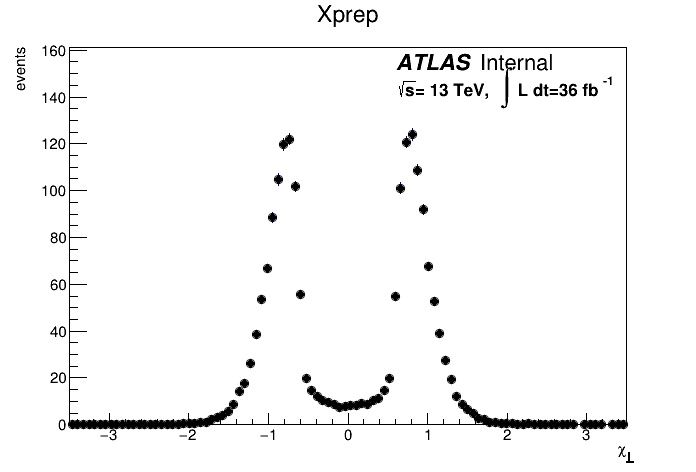

In [3]:

#possible samples: Sherpa_221_NNPDF30NNLO_WplvWmqq, PhPy8EG_A14_ttbar, Sherpa_221_NNPDF30NNLO
#samples = {"wjets":"Sherpa_221_NNPDF30NNLO", "ttbar":"PhPy8EG_A14_ttbar", "WplvWmqq":"Sherpa_221_NNPDF30NNLO_WplvWmqq"}

for mc_process in mc_processes:
    _leptons =leptons[mc_process]
    sample = samples[mc_process]
    for lepton in _leptons:
        if 'muon' in lepton: continue
        import time
        start = time.time()
        input_dir = "/eos/home-y/yabulait/wjets/ntuples/preselected/{0}/{1}/{2}/".format(mc_process, grid_date,lepton)
        files = [input_dir+f for f in os.listdir(input_dir)]
        muon_ds = [f.split('.')[0] for f in os.listdir(input_dir)]
    
        hist, h_deta_p, h_deta_n, h_asymmetry = calculate_asymmetry(files, save_to_files=True)
        
        save_dir = "/eos/home-y/yabulait/wjets/plots/pdf/SR/{}/".format(grid_date)
        if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        
        sys.path.append('/eos/home-y/yabulait/SWAN_projects/python')
        CM_energy="#sqrt{s}=13 TeV"
        from plotUtil import *
        AL = ROOT.TLatex() #l.SetTextAlign(12) l.SetTextSize(tsize) 
        AL.SetNDC()
        AL.SetTextFont(72)
        AL.SetTextColor(ROOT.kBlack)
        Inetrnal = ROOT.TLatex()
        Inetrnal.SetNDC()
        Inetrnal.SetTextFont(42)
        Inetrnal.SetTextColor(ROOT.kBlack)
        ## print text
        TL = ROOT.TLatex()
        TL.SetNDC(1)

        ROOT.gStyle.SetOptStat(0)
        c1 = ROOT.TCanvas()
        c1.SetGridy()
        if mc_process == "wjets":
            h_asymmetry.GetYaxis().SetRangeUser(-0.06,0.06)
        else:
            h_asymmetry.GetYaxis().SetRangeUser(-0.2,0.2)
        h_asymmetry.SetTitle("Left-Right Asymmetry")
        h_asymmetry.GetYaxis().SetTitle("Left-Right Asymmetry")
        h_asymmetry.GetXaxis().SetTitle("#Delta#eta (l-j)")
        h_asymmetry.SetMarkerStyle(20)
        h_asymmetry.Draw("hist e0")
        ROOT.gStyle.SetOptStat(0)
        ROOT.TH1.SetDefaultSumw2(1)

        #ATLAS_style(ROOT.gStyle)
        AL.DrawLatex(0.57,0.85,"ATLAS")
        Inetrnal.DrawLatex(0.69,0.85,"Internal")
        energy_lumi(0.57,0.80,13, Luminosity_fb)
        #TL.DrawLatex(0.65,0.85,CM_energy)
        c1.Draw()
        c1.Print("%s/%s_asymmetry_%s.pdf"%(save_dir,sample,lepton))
        
        c1 = ROOT.TCanvas()
        hist.SetMarkerStyle(20)
        hist.Draw("e0")
        _max = hist.GetMaximum()*1.30
        hist.GetYaxis().SetRangeUser(0,_max)
        hist.GetYaxis().SetTitle("events")
        hist.GetXaxis().SetTitle("#chi_{#perp}")
        AL.DrawLatex(0.57,0.85,"ATLAS")
        Inetrnal.DrawLatex(0.69,0.85,"Internal")
        energy_lumi(0.57,0.80,13, Luminosity_fb)
        c1.Draw()
        c1.Print("%s/%s_Xprep_%s.pdf"%(save_dir, sample,lepton))
        
        process_time = time.time() - start
        print("processing time = %.3fs"%(process_time))

In [4]:
!jupyter nbconvert --to python plot_asymmetry.ipynb

[NbConvertApp] Converting notebook plot_asymmetry.ipynb to python
[NbConvertApp] Writing 6804 bytes to plot_asymmetry.py
